<a href="https://colab.research.google.com/github/Robert202132437/snowy-pig/blob/main/codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Movie Recommendation System Based on Two-Tower Model**

**ST456 Deep Learning**

**Students: 38306, 26049, 29967**

# Datasets using in the two-tower model

In [8]:
import tensorflow_datasets as tfds
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [9]:
ratings_dataset, ratings_dataset_info = tfds.load(
    name='movielens/100k-ratings',
    split='train',
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0.incompleteKUUGZ0/movielens-train.tfrecord


  0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


In [10]:
# show the dataset
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
        'movie_title': rating['movie_title'],
        'user_rating': rating['user_rating'],
        'timestamp': rating['timestamp']
    }
)

print(
    tfds.as_dataframe(ratings_dataset.take(5), ratings_dataset_info)
)

  movie_id                                movie_title  timestamp user_id  \
0   b'357'  b"One Flew Over the Cuckoo's Nest (1975)"  879024327  b'138'   
1   b'709'                b'Strictly Ballroom (1992)'  875654590   b'92'   
2   b'412'             b'Very Brady Sequel, A (1996)'  882075110  b'301'   
3    b'56'                     b'Pulp Fiction (1994)'  883326919   b'60'   
4   b'895'                         b'Scream 2 (1997)'  891409199  b'197'   

   user_rating  
0          4.0  
1          2.0  
2          4.0  
3          4.0  
4          3.0  


In [11]:
# descriptive statistics
tfds.as_dataframe(ratings_dataset)['user_rating'].describe().round(2)

count    100000.00
mean          3.53
std           1.13
min           1.00
25%           3.00
50%           4.00
75%           4.00
max           5.00
Name: user_rating, dtype: float64

In [ ]:
## Split dataset randomly (70% for train and 30% for test)
trainset_size = 0.7 * ratings_dataset.__len__().numpy()
tf.random.set_seed(1)

# shuffle
ratings_dataset_shuffled = ratings_dataset.shuffle(
    buffer_size=100_000,
    seed=1,
    reshuffle_each_iteration=False
)
 
ratings_trainset = ratings_dataset_shuffled.take(trainset_size)
ratings_testset = ratings_dataset_shuffled.skip(trainset_size)

print(
    "ratings_trainset size: %d" % ratings_trainset.__len__()
)
print(
    "ratings_testset size: %d" % ratings_testset.__len__()
)

ratings_trainset size: 70000
ratings_testset size: 30000


In [ ]:
from pprint import pprint

for rating in ratings_trainset.take(1).as_numpy_iterator():
  pprint(rating)

{'movie_id': b'262',
 'movie_title': b'In the Company of Men (1997)',
 'timestamp': 877926419,
 'user_id': b'130',
 'user_rating': 3.0}


# Feature transformation

In [ ]:
# Make a Keras Normalization layer to standardize a numerical feature.
timestamp_normalization_layer = \
    tf.keras.layers.experimental.preprocessing.Normalization(axis=None)

# Normalization layer is a non-trainable layer and its state (mean and std of
# feature set) must be set before training in a step called "adaptation".
timestamp_normalization_layer.adapt(
    ratings_trainset.map(
        lambda x: x['timestamp']
    )
)

In [ ]:
# Make a Keras StringLookup layer as the mapping 
user_id_lookup_layer = \
    tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)

user_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['user_id']
    )
)

In [ ]:
# user id embedding
user_id_embedding_dim = 32

user_id_embedding_layer = tf.keras.layers.Embedding(
    input_dim=user_id_lookup_layer.vocabulary_size(),
    output_dim=user_id_embedding_dim
)
 
user_id_model = tf.keras.Sequential(
    [
        user_id_lookup_layer,
        user_id_embedding_layer
    ]
)

In [ ]:
# movie id embedding
movie_id_lookup_layer = \
    tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
movie_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['movie_id']
    )
)

movie_id_embedding_dim = 32

movie_id_embedding_layer = tf.keras.layers.Embedding(
    input_dim=movie_id_lookup_layer.vocabulary_size(),
    output_dim=movie_id_embedding_dim
)
 
movie_id_model = tf.keras.Sequential(
    [
        movie_id_lookup_layer,
        movie_id_embedding_layer
    ]
)

In [ ]:
# Keras TextVectorization layer transforms the raw texts into `word pieces` and map these pieces into tokens.
movie_title_vectorization_layer = \
    tf.keras.layers.experimental.preprocessing.TextVectorization()
movie_title_vectorization_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['movie_title']
    )
)

movie_title_embedding_dim = 32
movie_title_embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(movie_title_vectorization_layer.get_vocabulary()),
    output_dim=movie_title_embedding_dim,
    mask_zero=True
)

movie_title_model = tf.keras.Sequential(
    [
       movie_title_vectorization_layer,
       movie_title_embedding_layer,
       tf.keras.layers.GlobalAveragePooling1D()
    ]
)

# Building a two-tower model

In [ ]:
# Query tower
query_model = user_id_model
 
# Candidate tower
candidate_model = movie_id_model

# Retrieval task

In [ ]:
retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)
 
retrieval_ratings_testset = ratings_testset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)

In [ ]:
# To calculate the factorized top-k categorical accuracy we need the dataset of
# all possible candidates that are used as implicit negatives for evaluation.
movies_dataset, movies_dataset_info = tfds.load(
    name='movielens/100k-movies',
    split='train',
    with_info=True
)

print(
    tfds.as_dataframe(movies_dataset.take(5), movies_dataset_info)
)
 
# We are using just `movie_id` feature for making the candidates representation
candidates_corpus_dataset = movies_dataset.map(
    lambda movie: movie['movie_id']
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/movielens/100k-movies/0.1.0.incompleteT1FJMI/movielens-train.tfrecord


  0%|          | 0/1682 [00:00<?, ? examples/s]

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.
  movie_genres movie_id                      movie_title
0          [4]  b'1681'           b'You So Crazy (1994)'
1       [4, 7]  b'1457'   b'Love Is All There Is (1996)'
2       [1, 3]   b'500'          b'Fly Away Home (1996)'
3          [0]   b'838'  b'In the Line of Duty 2 (1987)'
4          [7]  b'1648'       b'Niagara, Niagara (1997)'


In [ ]:
## install the tensorflow-recommenders if you need
!pip install tensorflow-recommenders 

     |████████████████████████████████| 85 kB 5.4 MB/s 
     |████████████████████████████████| 462 kB 60.0 MB/s 


In [ ]:
import tensorflow_recommenders as tfrs

factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    candidates=candidates_corpus_dataset.batch(128).map(
        candidate_model
    )
)

In [ ]:
retrieval_task_layer = tfrs.tasks.Retrieval(
    metrics=factorized_top_k_metrics
)

In [ ]:
class RetrievalModel(tfrs.models.Model):
  """MovieLens candidate generation model"""
 
  def __init__(self, query_model, candidate_model, retrieval_task_layer):
    super().__init__()
    self.query_model: tf.keras.Model = query_model
    self.candidate_model: tf.keras.Model = candidate_model
    self.retrieval_task_layer: tf.keras.layers.Layer = retrieval_task_layer
 
  def compute_loss(self, features, training=False) -> tf.Tensor:
    query_embeddings = self.query_model(features['user_id'])
    positive_candidate_embeddings = self.candidate_model(features["movie_id"])

    loss = self.retrieval_task_layer(
        query_embeddings,
        positive_candidate_embeddings
        # ,compute_metrics=not training  # To speed up training
    )
    return loss

In [ ]:
# compile retrieval model
movielens_retrieval_model = RetrievalModel(
    query_model,
    candidate_model,
    retrieval_task_layer
)

optimizer_step_size = 0.1
movielens_retrieval_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(
        learning_rate=optimizer_step_size
    )
)

In [ ]:
# train
retrieval_cached_ratings_trainset = \
  retrieval_ratings_trainset.shuffle(100_000).batch(8192).cache()
retrieval_cached_ratings_testset = \
  retrieval_ratings_testset.batch(4096).cache()
 
num_epochs = 50 
history = movielens_retrieval_model.fit(
    retrieval_cached_ratings_trainset,
    validation_data=retrieval_cached_ratings_testset,
    validation_freq=1,
    epochs=num_epochs
)

Epoch 1/50
9/9 [==============================] - 22s 2s/step - factorized_top_k/top_1_categorical_accuracy: 4.2857e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0035 - factorized_top_k/top_50_categorical_accuracy: 0.0421 - factorized_top_k/top_100_categorical_accuracy: 0.0993 - loss: 66228.4352 - regularization_loss: 0.0000e+00 - total_loss: 66228.4352 - val_factorized_top_k/top_1_categorical_accuracy: 0.0026 - val_factorized_top_k/top_5_categorical_accuracy: 0.0180 - val_factorized_top_k/top_10_categorical_accuracy: 0.0358 - val_factorized_top_k/top_50_categorical_accuracy: 0.1558 - val_factorized_top_k/top_100_categorical_accuracy: 0.2694 - val_loss: 9319.2344 - val_regularization_loss: 0.0000e+00 - val_total_loss: 9319.2344
Epoch 2/50
9/9 [==============================] - 12s 1s/step - factorized_top_k/top_1_categorical_accuracy: 7.4286e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0110 - factorized_top_k/top_10_

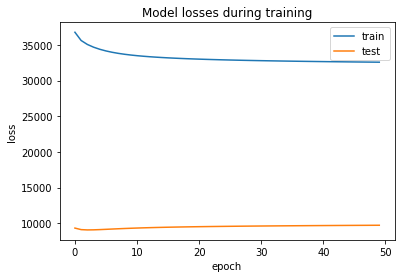

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()

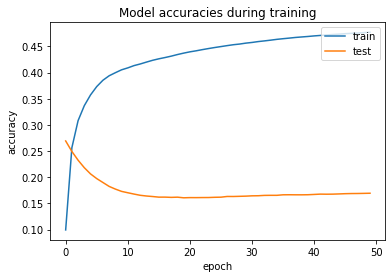

In [ ]:
# Plot changes in model accuracy during training
plt.plot(history.history["factorized_top_k/top_100_categorical_accuracy"])
plt.plot(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
plt.title("Model accuracies during training")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "test"], loc="upper right")
plt.show()

# Ranking task

In [ ]:
class RankingModel(tfrs.models.Model):
  """MovieLens ranking model"""

  def __init__(self, query_model, candidate_model):
    super().__init__()

    self.query_model: tf.keras.Model = query_model
    self.candidate_model: tf.keras.Model = candidate_model
    self.rating_model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1)
        ]
    )
    self.ranking_task_layer: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.RootMeanSquaredError()
        ]
    )


  def compute_loss(self, features, training=False) -> tf.Tensor:
    query_embeddings = self.query_model(features['user_id'])
    candidate_embeddings = self.candidate_model(features["movie_id"])
    rating_predictions = self.rating_model(
        tf.concat(
            [query_embeddings, candidate_embeddings],
            axis=1
        )
        # We could use `tf.keras.layers.Concatenate(axis=1)([x, y])`
    )

    loss = self.ranking_task_layer(
        predictions=rating_predictions,
        labels=features["user_rating"]
    )
    return loss

In [ ]:
# compile ranking model
movielens_ranking_model = RankingModel(query_model, candidate_model)

optimizer_step_size = 0.1
movielens_ranking_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(
        learning_rate=optimizer_step_size
    )
)

In [ ]:
# train
ranking_ratings_trainset = ratings_trainset.shuffle(100_000).batch(8192).cache()
ranking_ratings_testset = ratings_testset.batch(4096).cache()

History = movielens_ranking_model.fit(
    ranking_ratings_trainset,
    validation_data=ranking_ratings_testset,
    validation_freq=1,
    epochs=50
)

Epoch 1/50
9/9 [==============================] - 6s 337ms/step - root_mean_squared_error: 4.5516 - loss: 19.2396 - regularization_loss: 0.0000e+00 - total_loss: 19.2396 - val_root_mean_squared_error: 2.8745 - val_loss: 8.2759 - val_regularization_loss: 0.0000e+00 - val_total_loss: 8.2759
Epoch 2/50
9/9 [==============================] - 0s 12ms/step - root_mean_squared_error: 1.7183 - loss: 2.7299 - regularization_loss: 0.0000e+00 - total_loss: 2.7299 - val_root_mean_squared_error: 1.1692 - val_loss: 1.2487 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2487
Epoch 3/50
9/9 [==============================] - 0s 12ms/step - root_mean_squared_error: 1.1282 - loss: 1.2591 - regularization_loss: 0.0000e+00 - total_loss: 1.2591 - val_root_mean_squared_error: 1.0746 - val_loss: 1.0378 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0378
Epoch 4/50
9/9 [==============================] - 0s 13ms/step - root_mean_squared_error: 1.0657 - loss: 1.1383 - regularization_loss: 0

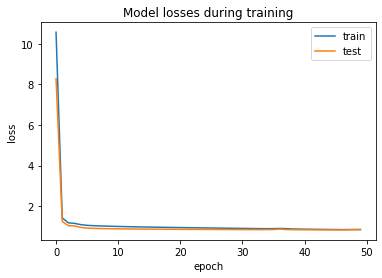

In [ ]:
# Plot changes in model loss during training
plt.plot(History.history["loss"])
plt.plot(History.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()

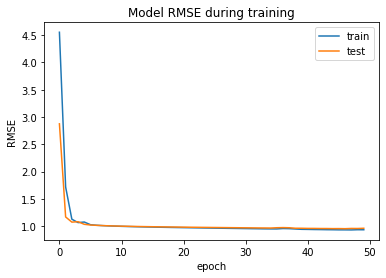

In [ ]:
# Plot changes in model loss during training
plt.plot(History.history["root_mean_squared_error"])
plt.plot(History.history["val_root_mean_squared_error"])
plt.title("Model RMSE during training")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(["train", "test"], loc="upper right")
plt.show()

# Comparison with CNN

## Datasets using in the CNN model


The datasets using in the CNN model is the same as using in the two-tower model.But we use different methods to input the datasets for preprocess conveniently.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
## since there are different feature vectors, we use different inputs format(upload the file into google drive),
## so that they can be fed to models conveniently. 
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow.compat.v1 as tf
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
import re
#from tensorflow.python.ops import math_ops

users_title = ['UserID', 'Age','Gender','Occupation', 'Zip-code']
users = pd.read_table('/content/drive/My Drive/u.user', sep='|', header=None, names=users_title, engine = 'python')

movies = pd.read_table('/content/drive/My Drive/u.item', sep='|', header=None, engine = 'python',encoding='ISO-8859-1')
array = np.array(movies.iloc[:,5:])
movies['Genres'] = array.tolist()
movies = movies.rename(columns = {0:'MovieID',1:'Title'})

ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('/content/drive/My Drive/u.data', sep='\t', header=None, names=ratings_title, engine = 'python')

In [31]:
## descriptive statistics
## we can see the data is consistent with the data we use in the two-tower model
ratings['Rating'].describe().round(2)

count    100000.00
mean          3.53
std           1.13
min           1.00
25%           3.00
50%           4.00
75%           4.00
max           5.00
Name: Rating, dtype: float64

## preprocess

In [4]:
def load_data():
    """
    Load Dataset from File
    """
    # user data
    users_title = ['UserID', 'Age','Gender','Occupation', 'Zip-code']
    users = pd.read_table('/content/drive/My Drive/u.user', sep='|', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Age|Gender|Occupation')
    users_orig = users.values
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    # dictionary of obs
    '''
    jobs_set = set()
    for val in users['Occupation'].str.split():
        jobs_set.update(val)

    jobs_set.add('<PAD>')
    jobs2int = {val:ii for ii, val in enumerate(jobs_set)}

    jobs_map = {val:[jobs2int[row] for row in val.split('|')] for ii,val in enumerate(set(users['Occupation']))}

    for key in jobs_map:
        for cnt in range(max(jobs2int.values()) - len(jobs_map[key])):
            jobs_map[key].insert(len(jobs_map[key]) + cnt,jobs2int['<PAD>'])
    
    users['JobID'] = users['Occupation'].map(jobs_map)
    '''
    category = pd.Categorical(users['Occupation'])
    users['JobID'] = category.codes
    
    # movie data
    movies = pd.read_table('/content/drive/My Drive/u.item', sep='|', header=None, engine = 'python',encoding='ISO-8859-1')
    array = np.array(movies.iloc[:,5:])
    movies['Genres'] = array.tolist()
    movies = movies.rename(columns = {0:'MovieID',1:'Title'})
    movies_orig = movies.values
    pattern = re.compile(r'^(.*)\((\d+)\)$')
    
    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title'])) if pattern.match(val)}
    movies['Title'] = movies['Title'].map(title_map)


    # dictionary of movie titles
    title_count = 15

    title_set = set()
    for val in movies['Title'].str.split():
        if type(val) == float:
            val = ['Babe']
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}

    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title'])) if type(val)!=float}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_map)

    # rating data
    ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
    ratings = pd.read_table('/content/drive/My Drive/u.data', sep='\t', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|Rating')

    data = pd.merge(pd.merge(ratings, users), movies)
    data = data[['UserID','MovieID','Rating','Age','Gender','JobID','Title','Genres']]
    gender = data.Gender
    data = data.drop('Gender',axis=1)
    data.insert(3,'Gender',gender) 
    data = data.dropna()
    
    target_fields = ['Rating']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set,  features, targets_values, ratings, users, movies, data, movies_orig, users_orig

In [5]:
title_count, title_set,  features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((title_count, title_set,  features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

In [6]:
title_count, title_set,  features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

## model building

In [12]:
users = users.filter(regex='UserID|Age|Gender|JobID')
users

,UserID,Age,Gender,JobID
0,1,14,1,19
1,2,43,0,13
2,3,13,1,20
3,4,14,1,19
4,5,23,0,13
...,...,...,...,...
938,939,16,0,18
939,940,22,1,0
940,941,10,1,18
941,942,38,0,10


In [13]:
#import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


In [14]:
# embedding dimension
embed_dim = 32
# user ID number
uid_max = max(features.take(0,1)) + 1 # 6040
# gender number
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
# age number
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
# job number
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21
#job_max = 21

# movie ID number
movie_id_max = max(features.take(1,1)) + 1 # 3952
# movie genre number
#movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
movie_categories_max = 19
# movie name number
movie_title_max = len(title_set) # 5216

combiner = "sum"

sentences_size = title_count # = 15
window_sizes = {2, 3, 4, 5}
# filter number
filter_num = 8

# The movie ID in the dataset is inconsistent with the subscript
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

In [15]:
# Number of Epochs
num_epochs = 50
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.01
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

In [16]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 19], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

In [17]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
    
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
        
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

In [18]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        # the first layer
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        
        # the second layer
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
        #user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
        user_combine_layer = tf_slim.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

In [19]:
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

In [20]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    #     elif combiner == "mean":

    return movie_categories_embed_layer

In [21]:
def get_movie_cnn_layer(movie_titles):
    # movie embedding
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
    # convolution and pooling
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)

    # Dropout layer
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

In [22]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        # the first layer
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        # the second layer
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        #movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
        movie_combine_layer = tf_slim.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

In [23]:
## install the tensorflow-slim if you need
!pip install tf_slim

     |████████████████████████████████| 352 kB 5.4 MB/s 


In [ ]:
import tf_slim

tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    # embedding vector of user
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    # user features
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                dropout_layer)
    # calculate ratings
    with tf.name_scope("inference"):
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        cost = tf.losses.mean_squared_error(targets, inference )+0.5
        loss = tf.reduce_mean(cost)
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)
    

In [28]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

## results

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #split train and test set
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.3,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        # training iteration
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 19])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  #
            
            # Show every <show_every_n_batches> batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   RMSE = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        # testing iteration
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 19])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   RMSE = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')


Writing to /content/runs/1650813700

2022-04-24T15:21:42.862029: Epoch   0 Batch    0/273   RMSE = 19.627
2022-04-24T15:21:43.743362: Epoch   0 Batch   20/273   RMSE = 8.342
2022-04-24T15:21:44.922927: Epoch   0 Batch   40/273   RMSE = 2.948
2022-04-24T15:21:46.266638: Epoch   0 Batch   60/273   RMSE = 1.984
2022-04-24T15:21:47.812686: Epoch   0 Batch   80/273   RMSE = 1.928
2022-04-24T15:21:49.222121: Epoch   0 Batch  100/273   RMSE = 1.916
2022-04-24T15:21:50.342336: Epoch   0 Batch  120/273   RMSE = 1.597
2022-04-24T15:21:51.782541: Epoch   0 Batch  140/273   RMSE = 1.823
2022-04-24T15:21:53.268907: Epoch   0 Batch  160/273   RMSE = 1.697
2022-04-24T15:21:54.808500: Epoch   0 Batch  180/273   RMSE = 1.779
2022-04-24T15:21:56.279390: Epoch   0 Batch  200/273   RMSE = 1.633
2022-04-24T15:21:57.707964: Epoch   0 Batch  220/273   RMSE = 1.744
2022-04-24T15:21:59.183007: Epoch   0 Batch  240/273   RMSE = 1.707
2022-04-24T15:22:00.665637: Epoch   0 Batch  260/273   RMSE = 1.419
2022-04-24